In [1]:
import os
import json
import subprocess

In [2]:
# path in which datasets are stored
datasets_folder = "../datasets"

# trec EVAL executable
trec_exec = "trec_eval/trec_eval"

# path of the qrels file
qrels_fp = "qrels.txt"

# path that stores the IDs of the empty files
empty_fp = "EMPTY/empty-datasets.txt"

acordar_run_fp = "ACORDAR/BM25F.txt"
my_run_fp = "REPR/BM25-META+EXTRACTED-ALL-QUERIES-output.txt"

# Find empty datasets
Empty datasets are datasets for which no RDF file has been used.
This can be due to download or parsing errors

In [3]:
datasets = [int(id) for id in open(empty_fp).readlines()]

In [4]:
empty_datasets = sorted(datasets, key=lambda i: int(i))

In [5]:
print(f"EMPTY DATASETS {len(empty_datasets)}")

EMPTY DATASETS 5201


Find queries that have in the relevance judgements at least one dataset that is "empty" (i.e. no RDF file has been used to extract data for the given dataset)

In [6]:
# (query_id, list of empty datasets that are relevant for the query)
affected = dict()

with open(qrels_fp, "r") as qrels_file:
    for line in qrels_file:
        tokens = line.split("\t")

        query_id = int(tokens[0])
        dataset_id = int(tokens[2])
        relevance_val = int(tokens[3].strip("\n"))

        if dataset_id in empty_datasets and relevance_val > 0:
            if query_id not in affected.keys():
                affected[query_id] = set()
            affected[query_id].add(dataset_id)

In [7]:
print("Number of affected queries: "+str(len(affected.keys())))

Number of affected queries: 213


# Compare run

In [8]:
def rank_affected_queries(path_run: str, affected: dict) -> dict:
    ranks = dict()

    with open(path_run, "r") as run:
        for line in run:

            split = line.split("\t")

            query_id = int(split[0])
            dataset_id = int(split[2])

            if query_id not in affected:
                continue

            if query_id not in ranks:
                ranks[query_id] = list()

            ranks[query_id].append(dataset_id)                

    return ranks

In [9]:
acordar_ranks = rank_affected_queries(acordar_run_fp, affected)
my_ranks = rank_affected_queries(my_run_fp, affected)

print(len(acordar_ranks.keys()))
print(len(my_ranks.keys()))

213
213


In [10]:
# List of empty datasets returned from ACORDAR
empty_returned_by_acordar = dict()

for query, rank in acordar_ranks.items():
    empty_datasets_returned = set.intersection(set(rank), set(empty_datasets))
    if len(empty_datasets_returned) > 0:
        empty_returned_by_acordar[query] = empty_datasets_returned

In [11]:
print(f"Number of queries affected by empty datasets in ACORDAR: {len(empty_returned_by_acordar)}")

Number of queries affected by empty datasets in ACORDAR: 162


In [12]:
# For every query affected by empty datasets, find datasets returned by ACORDAR but not by me
not_returned_datasets_wrt_acordar = dict()

for query, empty_datasets_acordar in empty_returned_by_acordar.items():
    if not empty_datasets_acordar.issubset(my_ranks[query]):
        datasets = set()
        for empty_dataset in empty_datasets_acordar:
            if empty_dataset not in my_ranks[query]:
                datasets.add(empty_dataset)
        not_returned_datasets_wrt_acordar[query] = datasets

In [13]:
print(f"Number of queries having empty datasets that are returned by ACORDAR but not returned by me: {len(not_returned_datasets_wrt_acordar.keys())}")

Number of queries having empty datasets that are returned by ACORDAR but not returned by me: 94


In [14]:
for e,l in sorted(not_returned_datasets_wrt_acordar.items(), key=lambda x:len(x[1]), reverse= True):
    print(f"QUERY ID: {e}\t EMPTY DATASETS {l}")

QUERY ID: 1106	 EMPTY DATASETS {41092, 41132, 9776, 41073, 41136, 7542, 11831}
QUERY ID: 224	 EMPTY DATASETS {72932, 13349, 72934, 72935, 72909, 14509, 72877}
QUERY ID: 158	 EMPTY DATASETS {21569, 3106, 63268, 14735, 15250, 13815}
QUERY ID: 189	 EMPTY DATASETS {83073, 82596, 10036, 10037, 83612}
QUERY ID: 1042	 EMPTY DATASETS {15779, 15786, 15788, 15762, 15771}
QUERY ID: 1203	 EMPTY DATASETS {961, 1859, 969, 1103, 4053}
QUERY ID: 147	 EMPTY DATASETS {9381, 8970, 15788, 69292, 69166}
QUERY ID: 22	 EMPTY DATASETS {43248, 2690, 9464, 11888}
QUERY ID: 112	 EMPTY DATASETS {29436, 11285, 63268, 63269}
QUERY ID: 1004	 EMPTY DATASETS {15753, 15786, 15779, 15771}
QUERY ID: 1219	 EMPTY DATASETS {25048, 1986, 85767, 25119}
QUERY ID: 1183	 EMPTY DATASETS {68651, 69027, 55435, 9017}
QUERY ID: 188	 EMPTY DATASETS {28744, 28924, 10037, 84478}
QUERY ID: 1052	 EMPTY DATASETS {41136, 11795, 41132, 41087}
QUERY ID: 1241	 EMPTY DATASETS {21569, 43218, 11802, 11789}
QUERY ID: 170	 EMPTY DATASETS {11832, 11

In [15]:
histogram = dict()

for query, empty_datasets_not_returned in sorted(not_returned_datasets_wrt_acordar.items(), key=lambda x:len(x[1]), reverse= True):
    missing = len(empty_datasets_not_returned)

    if missing not in histogram.keys():
        histogram[missing] = []

    histogram[missing].append(query)

In [16]:
for missing, query_list in histogram.items():
    print(f"{len(query_list)} queries have {missing} missing datasets")

2 queries have 7 missing datasets
1 queries have 6 missing datasets
4 queries have 5 missing datasets
9 queries have 4 missing datasets
7 queries have 3 missing datasets
29 queries have 2 missing datasets
42 queries have 1 missing datasets


# Evaluate P@10 using TREC EVAL

In [17]:
def calculate_trec_p10_for_each_query(
    trec_exec: str, qrels_fp: str, run_fp: str
) -> dict:
    trec_cmd = f"{trec_exec} -q -m P.10 {qrels_fp} {run_fp}"

    output = subprocess.check_output(trec_cmd, shell=True, encoding="utf-8")

    query_prec = dict()
    for line in output.split("\n"):
        tokens = line.split()
        if len(tokens) == 3 and tokens[1].isnumeric():
            query_id = int(tokens[1])
            p_10 = tokens[2]
            query_prec[query_id] = p_10

    return query_prec

In [18]:
acordar_p10_pq = calculate_trec_p10_for_each_query(trec_exec, qrels_fp, acordar_run_fp)
my_run_p10_pq = calculate_trec_p10_for_each_query(trec_exec, qrels_fp, my_run_fp)

In [19]:
assert(acordar_p10_pq.keys() == my_run_p10_pq.keys())

In [20]:
compare_precisions = list()

for query_id in acordar_p10_pq.keys():
    acordar_value = float(acordar_p10_pq[query_id])
    my_value = float(my_run_p10_pq[query_id])
    diff = acordar_value - my_value
    missing_empty_dataset_wrt_acordar = (
        len(not_returned_datasets_wrt_acordar[query_id])
        if query_id in not_returned_datasets_wrt_acordar.keys()
        else 0
    )
    compare_precisions.append(
        {
            "query-id": query_id,
            "p10-acordar": round(acordar_value, 4),
            "p10-my": round(my_value, 4),
            "diff": round(diff, 4),
            "len-empty-datasets-wrt-acordar": missing_empty_dataset_wrt_acordar,
        }
    )

In [21]:
for item in sorted(compare_precisions, key=lambda e: e["diff"], reverse=True):
    print(f"QUERY {item['query-id']}\t P10-ACORDAR:{item['p10-acordar']}\t P10-MY:{item['p10-my']}\t DIFF:{item['diff']}\t # EMPTY MISSING: {item['len-empty-datasets-wrt-acordar']}")

QUERY 90	 P10-ACORDAR:1.0	 P10-MY:0.1	 DIFF:0.9	 # EMPTY MISSING: 2
QUERY 1106	 P10-ACORDAR:1.0	 P10-MY:0.3	 DIFF:0.7	 # EMPTY MISSING: 7
QUERY 1052	 P10-ACORDAR:1.0	 P10-MY:0.4	 DIFF:0.6	 # EMPTY MISSING: 4
QUERY 1141	 P10-ACORDAR:0.7	 P10-MY:0.1	 DIFF:0.6	 # EMPTY MISSING: 0
QUERY 96	 P10-ACORDAR:0.7	 P10-MY:0.1	 DIFF:0.6	 # EMPTY MISSING: 2
QUERY 1036	 P10-ACORDAR:0.6	 P10-MY:0.1	 DIFF:0.5	 # EMPTY MISSING: 1
QUERY 1182	 P10-ACORDAR:1.0	 P10-MY:0.5	 DIFF:0.5	 # EMPTY MISSING: 0
QUERY 1203	 P10-ACORDAR:0.7	 P10-MY:0.2	 DIFF:0.5	 # EMPTY MISSING: 5
QUERY 20	 P10-ACORDAR:0.5	 P10-MY:0.0	 DIFF:0.5	 # EMPTY MISSING: 0
QUERY 251	 P10-ACORDAR:0.5	 P10-MY:0.0	 DIFF:0.5	 # EMPTY MISSING: 0
QUERY 30	 P10-ACORDAR:0.9	 P10-MY:0.4	 DIFF:0.5	 # EMPTY MISSING: 0
QUERY 86	 P10-ACORDAR:0.5	 P10-MY:0.0	 DIFF:0.5	 # EMPTY MISSING: 0
QUERY 1003	 P10-ACORDAR:0.8	 P10-MY:0.4	 DIFF:0.4	 # EMPTY MISSING: 0
QUERY 103	 P10-ACORDAR:0.5	 P10-MY:0.1	 DIFF:0.4	 # EMPTY MISSING: 0
QUERY 1043	 P10-ACORDAR:0.8	 P10

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(compare_precisions)

In [23]:
# Group the DataFrame by 'diff' and 'len-empty-datasets-wrt-acordar' columns
grouped = df.groupby(['diff', 'len-empty-datasets-wrt-acordar']).size().reset_index(name='count')

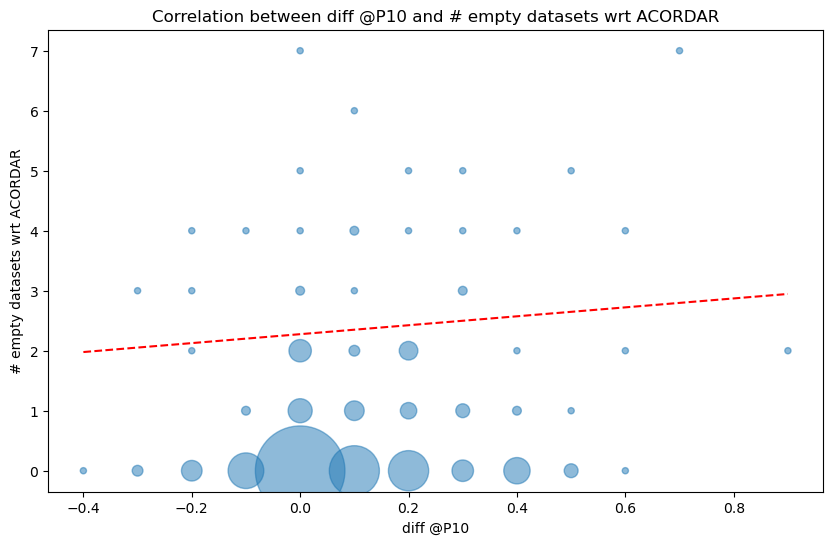

In [24]:
# Scatter plot with size based on the count of points collapsing to the same value
plt.figure(figsize=(10, 6))
plt.scatter(grouped['diff'], grouped['len-empty-datasets-wrt-acordar'], s=grouped['count'] * 20, alpha=0.5)

# Adding labels and title
plt.xlabel('diff @P10')
plt.ylabel('# empty datasets wrt ACORDAR')
plt.title('Correlation between diff @P10 and # empty datasets wrt ACORDAR')

# Fit a linear regression line
m, b = np.polyfit(grouped['diff'], grouped['len-empty-datasets-wrt-acordar'], 1)

# Create a line using the regression coefficients
x = np.linspace(grouped['diff'].min(), grouped['diff'].max(), 100)
y = m * x + b

# Plot the regression line
plt.plot(x, y, color='red', linestyle='--', label='Regression Line')

# Show the plot
plt.savefig(f"empty_datasets_precision_correlation.svg", format="svg")